In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Custom Model

In [2]:
from tensorflow import keras
from keras.layers import MaxPooling2D, BatchNormalization, Activation, Conv2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.layers import Input
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers import GlobalAveragePooling2D
import cv2

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# for pytorch
import torchvision
import torchvision.transforms as transforms

# Define data transformations ( optional , but recommended )
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5 , 0.5 , 0.5), (0.5 , 0.5 , 0.5))])

# Load the training dataset
train_dataset = torchvision.datasets.CIFAR10(root ='./data', train = True, transform = transform, download = True)
# Load the testing dataset
test_dataset = torchvision.datasets.CIFAR10(root ='./data', train = False, transform = transform, download = True)

# for keras
from keras.datasets import cifar10

# Load the CIFAR -10 dataset
(train_images , train_labels), (test_images, test_labels) = cifar10.load_data()


100%|██████████| 170498071/170498071 [00:03<00:00, 49555454.60it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
170498071/170498071 [==============================] - 5s 0us/step


In [4]:
train_images = train_images/255.0
test_images = test_images/255.0
train_images.shape , train_labels.shape

((50000, 32, 32, 3), (50000, 1))

In [5]:
train_labels_one_hot = to_categorical(train_labels, num_classes=10)
test_labels_one_hot = to_categorical(test_labels, num_classes=10)

In [6]:
# Define the model architecture
def build_model(inputs, filters, d, kernel_size = 3): 
    "filters: [x1, x2, x3]"
    x = Conv2D(filters[0], kernel_size, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(filters[1], kernel_size, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)

    x = Dense(filters[2], activation='relu')(x)
    x = Dropout(d)(x)
    x = Dense(10, activation='softmax')(x)

    return x

### Learning Rate 0.0001

In [7]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
output = build_model(inputs, filters=[64, 128, 256], d=0.01)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_0001 = keras.Model(inputs=inputs, outputs=output)
model_0001.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

In [8]:
history = model_0001.fit(train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
model_0001.save('cifar10_0001.h5')
print("Saved model to disk")

df = pd.DataFrame(history.history)
df.to_csv("history_0001.csv")

Epoch 1/20
625/625 [==============================] - 16s 8ms/step - loss: 1.4327 - accuracy: 0.4890 - val_loss: 1.3217 - val_accuracy: 0.5268
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 1.0776 - accuracy: 0.6191 - val_loss: 1.1247 - val_accuracy: 0.6031
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 0.9236 - accuracy: 0.6749 - val_loss: 0.9771 - val_accuracy: 0.6595
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.8185 - accuracy: 0.7150 - val_loss: 1.0271 - val_accuracy: 0.6459
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7261 - accuracy: 0.7473 - val_loss: 0.9559 - val_accuracy: 0.6652
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 0.6573 - accuracy: 0.7746 - val_loss: 0.9550 - val_accuracy: 0.6738
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 0.5878 - accuracy: 0.7982 - val_loss: 0.9157 - val_accuracy: 0.6918
Epoch

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
model = keras.models.load_model('cifar10_0001.h5')

In [10]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 1.0435 - accuracy: 0.7133
Test accuracy: 0.7132999897003174


313/313 [==============================] - 1s 2ms/step


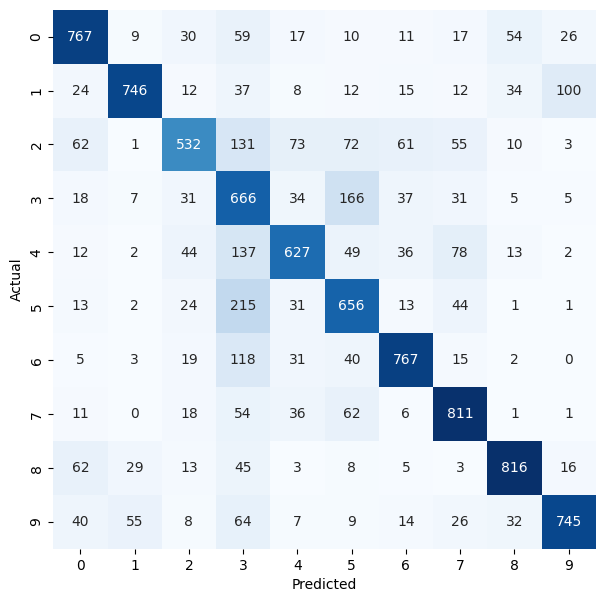

In [11]:
# Assuming you have a trained model and test data X_test
y_pred = model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

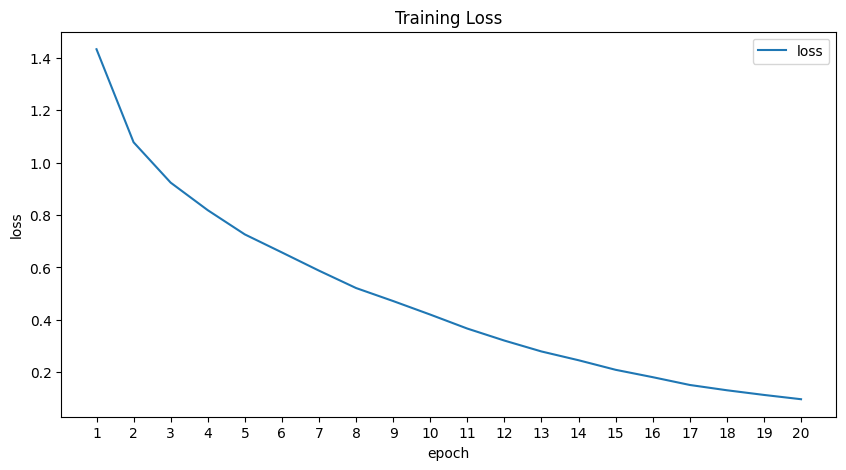

In [12]:
# reading the csv file
df = pd.read_csv('history_0001.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Training Loss')
ax.legend()
plt.show()

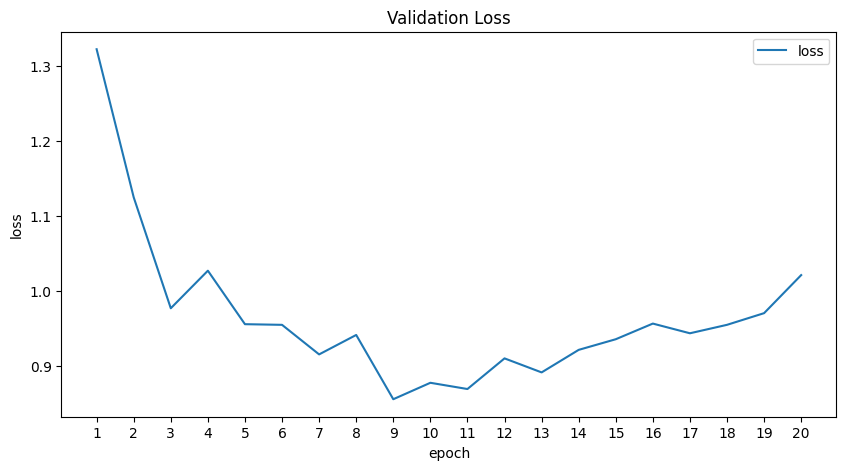

In [13]:
# reading the csv file
df = pd.read_csv('history_0001.csv')
loss = df['val_loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Validation Loss')
ax.legend()
plt.show()

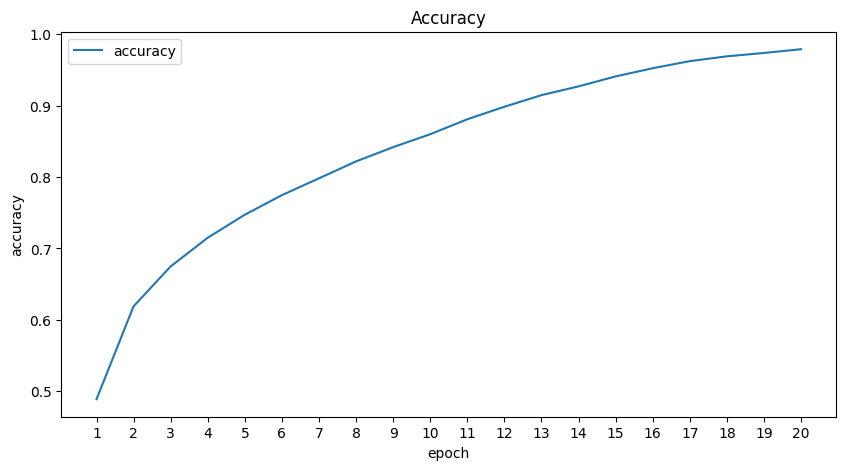

In [14]:
# reading the csv file
df = pd.read_csv('history_0001.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

### Learning Rate 0.001

In [15]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
output = build_model(inputs, filters=[64, 128, 256], d=0.01)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.001)

model_001 = keras.Model(inputs=inputs, outputs=output)
model_001.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

In [16]:
history = model_001.fit(train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
model_001.save('cifar10_001.h5')
print("Saved model to disk")

df = pd.DataFrame(history.history)
df.to_csv("history_001.csv")

Epoch 1/20
625/625 [==============================] - 7s 8ms/step - loss: 1.6886 - accuracy: 0.4357 - val_loss: 1.2938 - val_accuracy: 0.5434
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 1.1193 - accuracy: 0.6040 - val_loss: 1.0550 - val_accuracy: 0.6336
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 0.9757 - accuracy: 0.6585 - val_loss: 0.9537 - val_accuracy: 0.6708
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 0.8908 - accuracy: 0.6902 - val_loss: 0.9406 - val_accuracy: 0.6671
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 0.8209 - accuracy: 0.7155 - val_loss: 1.4070 - val_accuracy: 0.5452
Epoch 6/20
625/625 [==============================] - 5s 7ms/step - loss: 0.7631 - accuracy: 0.7329 - val_loss: 0.9665 - val_accuracy: 0.6759
Epoch 7/20
625/625 [==============================] - 4s 7ms/step - loss: 0.7052 - accuracy: 0.7531 - val_loss: 0.9556 - val_accuracy: 0.6853
Epoch 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model = keras.models.load_model('cifar10_001.h5')

In [18]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 1.1521 - accuracy: 0.7008
Test accuracy: 0.7008000016212463


313/313 [==============================] - 1s 2ms/step


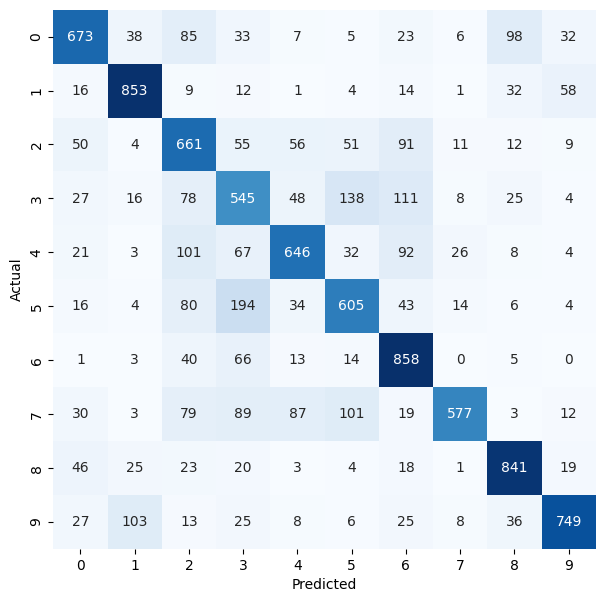

In [19]:
# Assuming you have a trained model and test data X_test
y_pred = model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

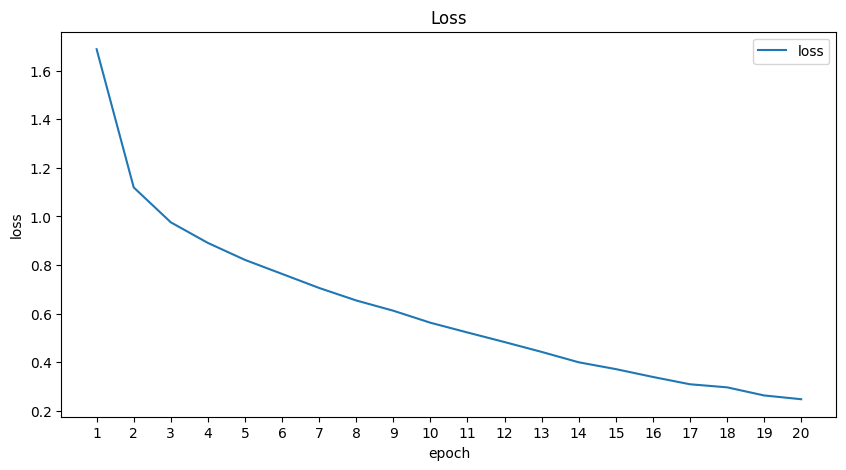

In [20]:
# reading the csv file
df = pd.read_csv('history_001.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

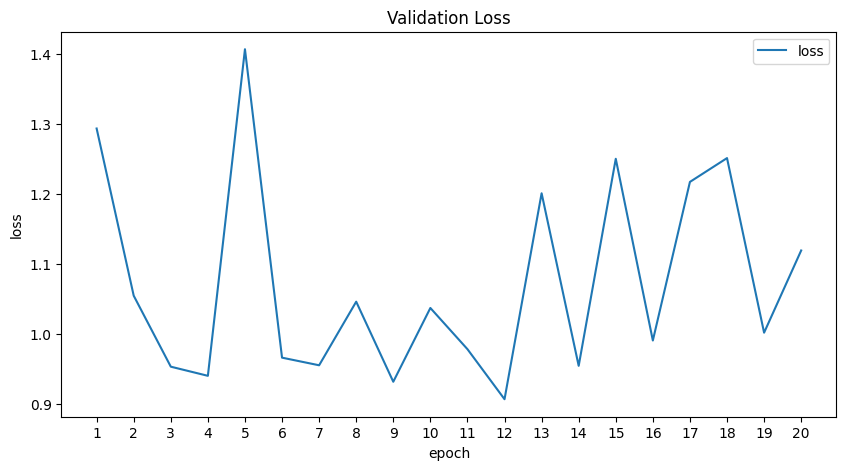

In [21]:
# reading the csv file
df = pd.read_csv('history_001.csv')
loss = df['val_loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Validation Loss')
ax.legend()
plt.show()

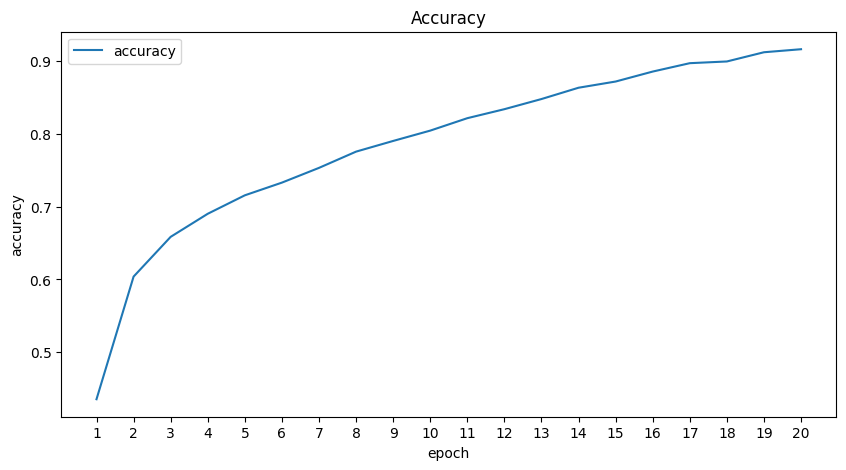

In [22]:
# reading the csv file
df = pd.read_csv('history_001.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

### Learning Rate 0.01

In [23]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
output = build_model(inputs, filters=[64, 128, 256], d=0.01)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.01)

model_01 = keras.Model(inputs=inputs, outputs=output)
model_01.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

In [24]:
history = model_01.fit(train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
model_01.save('cifar10_01.h5')
print("Saved model to disk")

df = pd.DataFrame(history.history)
df.to_csv("history_01.csv")

Epoch 1/20
625/625 [==============================] - 8s 9ms/step - loss: 3.1324 - accuracy: 0.2560 - val_loss: 2.4002 - val_accuracy: 0.1491
Epoch 2/20
625/625 [==============================] - 4s 7ms/step - loss: 1.6229 - accuracy: 0.3653 - val_loss: 1.6135 - val_accuracy: 0.3649
Epoch 3/20
625/625 [==============================] - 4s 7ms/step - loss: 1.4601 - accuracy: 0.4387 - val_loss: 2.3364 - val_accuracy: 0.2825
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 1.2862 - accuracy: 0.5198 - val_loss: 1.2273 - val_accuracy: 0.5567
Epoch 5/20
625/625 [==============================] - 4s 7ms/step - loss: 1.1575 - accuracy: 0.5772 - val_loss: 1.3099 - val_accuracy: 0.5390
Epoch 6/20
625/625 [==============================] - 4s 7ms/step - loss: 1.0772 - accuracy: 0.6120 - val_loss: 1.1942 - val_accuracy: 0.5652
Epoch 7/20
625/625 [==============================] - 5s 7ms/step - loss: 1.0160 - accuracy: 0.6348 - val_loss: 1.1268 - val_accuracy: 0.5975
Epoch 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
model = keras.models.load_model('cifar10_01.h5')

In [26]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 1.3697 - accuracy: 0.6059
Test accuracy: 0.60589998960495


313/313 [==============================] - 1s 2ms/step


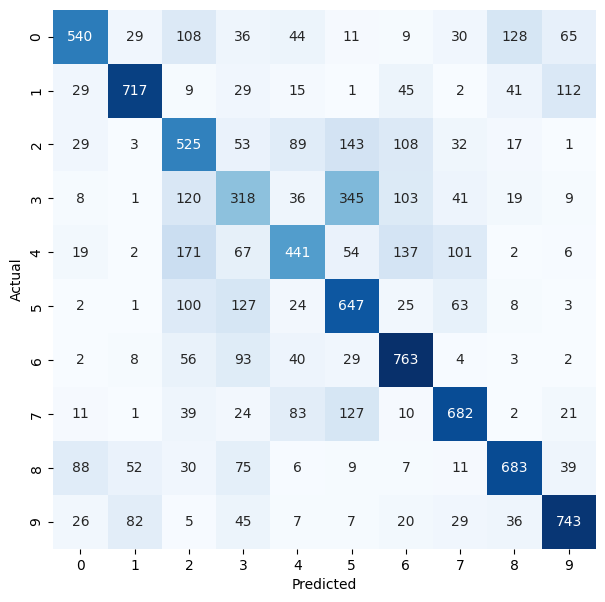

In [27]:
# Assuming you have a trained model and test data X_test
y_pred = model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

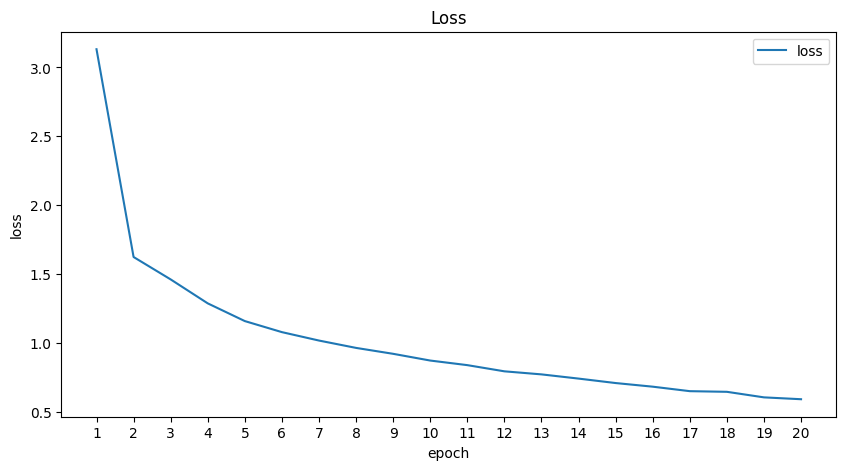

In [28]:
# reading the csv file
df = pd.read_csv('history_01.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

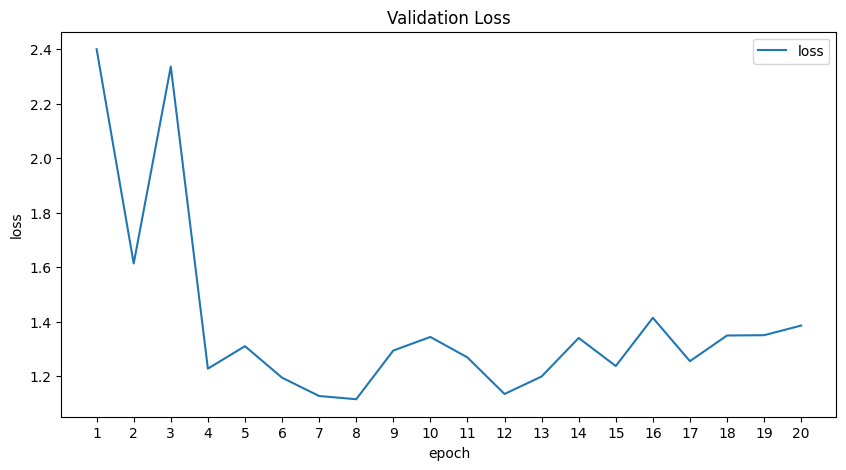

In [29]:
# reading the csv file
df = pd.read_csv('history_01.csv')
loss = df['val_loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Validation Loss')
ax.legend()
plt.show()

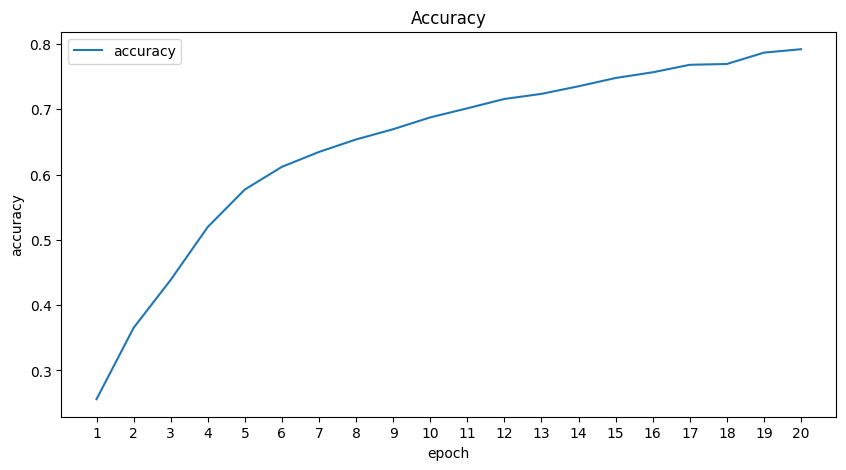

In [30]:
# reading the csv file
df = pd.read_csv('history_01.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

### Learning Rate 0.1

In [31]:
input_shape = (32, 32, 3)
inputs = Input(shape=input_shape)
output = build_model(inputs, filters=[64, 128, 256], d=0.01)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.1)

model_1 = keras.Model(inputs=inputs, outputs=output)
model_1.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

In [42]:
history = model_1.fit(train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
model_1.save('cifar10_1.h5')
print("Saved model to disk")

df = pd.DataFrame(history.history)
df.to_csv("history_1.csv")

Epoch 1/20
625/625 [==============================] - 5s 8ms/step - loss: 2.3112 - accuracy: 0.1015 - val_loss: 2.3079 - val_accuracy: 0.0952
Epoch 2/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3118 - accuracy: 0.0988 - val_loss: 2.3105 - val_accuracy: 0.1025
Epoch 3/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3113 - accuracy: 0.0988 - val_loss: 2.3087 - val_accuracy: 0.0997
Epoch 4/20
625/625 [==============================] - 4s 7ms/step - loss: 2.3119 - accuracy: 0.1000 - val_loss: 2.3155 - val_accuracy: 0.1014
Epoch 5/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3128 - accuracy: 0.0979 - val_loss: 2.3065 - val_accuracy: 0.1003
Epoch 6/20
625/625 [==============================] - 5s 8ms/step - loss: 2.3114 - accuracy: 0.0965 - val_loss: 2.3081 - val_accuracy: 0.1022
Epoch 7/20
625/625 [==============================] - 5s 7ms/step - loss: 2.3119 - accuracy: 0.0995 - val_loss: 2.3125 - val_accuracy: 0.1014
Epoch 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
model = keras.models.load_model('cifar10_1.h5')

In [44]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels_one_hot)
print(f'Test accuracy: {test_accuracy}')

313/313 [==============================] - 1s 3ms/step - loss: 2.3097 - accuracy: 0.1000
Test accuracy: 0.10000000149011612


313/313 [==============================] - 1s 2ms/step


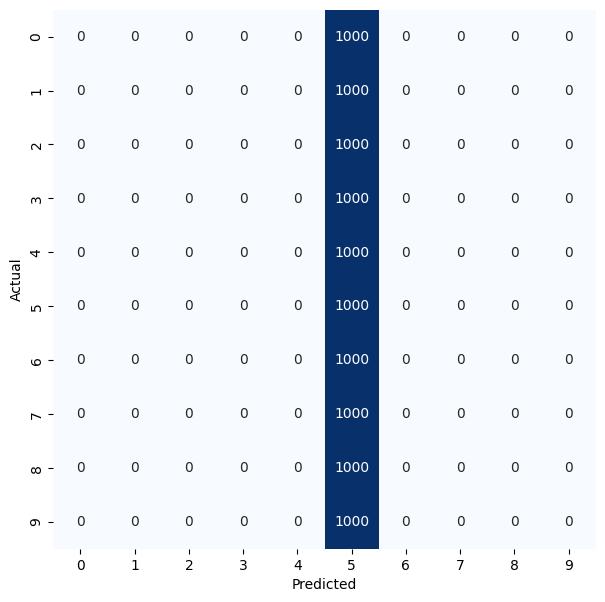

In [45]:
# Assuming you have a trained model and test data X_test
y_pred = model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

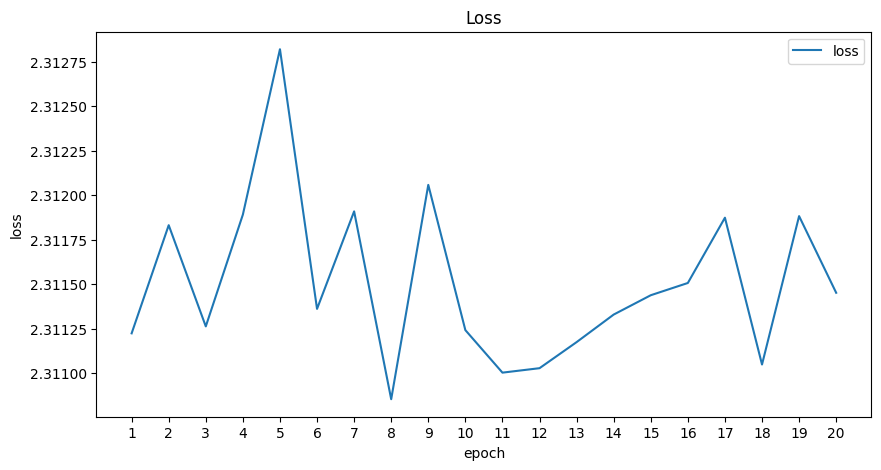

In [46]:
# reading the csv file
df = pd.read_csv('history_1.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

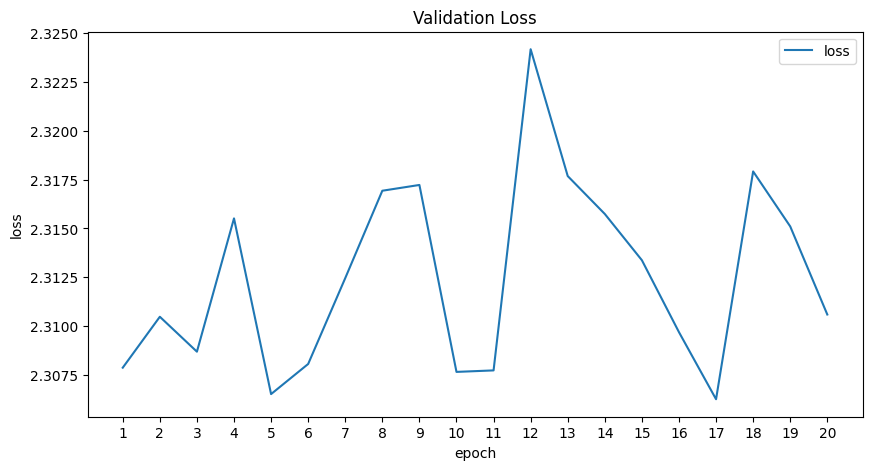

In [47]:
# reading the csv file
df = pd.read_csv('history_1.csv')
loss = df['val_loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Validation Loss')
ax.legend()
plt.show()

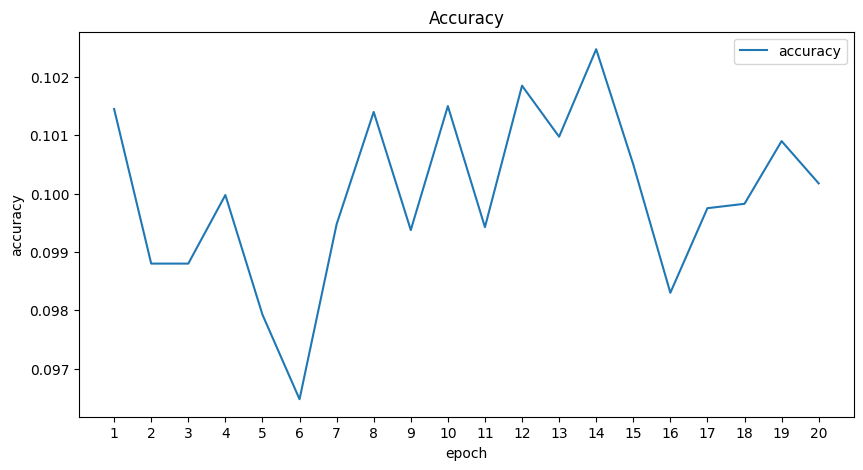

In [48]:
# reading the csv file
df = pd.read_csv('history_1.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

### Using GoogleNET (InceptionV3)

In [57]:
from keras.applications import InceptionV3

googlenet_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [58]:
resized_train_images = []
resized_test_images = []

# Loop through each image in the original dataset and resize it
for image in train_images:
    resized_image = cv2.resize(image, (75, 75))
    resized_train_images.append(resized_image)
    
for image in test_images:
    resized_image = cv2.resize(image, (75, 75))
    resized_test_images.append(resized_image)

resized_train_images = np.array(resized_train_images)
resized_test_images = np.array(resized_test_images)
    
train_images.shape, resized_train_images.shape, resized_test_images.shape

((50000, 32, 32, 3), (50000, 75, 75, 3), (10000, 75, 75, 3))

In [59]:
x = googlenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(10, activation='relu')(x)

from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Adjust the clipvalue as needed

inceptionv3_model = keras.models.Model(inputs=googlenet_model.input, outputs=x)
inceptionv3_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


In [60]:
inceptionv3_history = inceptionv3_model.fit(resized_train_images, train_labels_one_hot, batch_size=64, epochs=20, verbose="auto", validation_split=0.2)
inceptionv3_model.save('inceptionv3.h5')
print("Saved model to disk")

df = pd.DataFrame(inceptionv3_history.history)
df.to_csv("inception_history.csv")

Epoch 1/20
625/625 [==============================] - 85s 74ms/step - loss: 3.4476 - accuracy: 0.2050 - val_loss: 3.2170 - val_accuracy: 0.2615
Epoch 2/20
625/625 [==============================] - 43s 68ms/step - loss: 3.4805 - accuracy: 0.1682 - val_loss: 3.5313 - val_accuracy: 0.1680
Epoch 3/20
625/625 [==============================] - 43s 68ms/step - loss: 3.3375 - accuracy: 0.1929 - val_loss: 3.1378 - val_accuracy: 0.2020
Epoch 4/20
625/625 [==============================] - 43s 68ms/step - loss: 3.3943 - accuracy: 0.1799 - val_loss: 3.2437 - val_accuracy: 0.1953
Epoch 5/20
625/625 [==============================] - 43s 68ms/step - loss: 3.4007 - accuracy: 0.1994 - val_loss: 3.5441 - val_accuracy: 0.1031
Epoch 6/20
625/625 [==============================] - 43s 68ms/step - loss: 3.4298 - accuracy: 0.1608 - val_loss: 3.5304 - val_accuracy: 0.0858
Epoch 7/20
625/625 [==============================] - 43s 68ms/step - loss: 3.4082 - accuracy: 0.1688 - val_loss: 3.4960 - val_accuracy:

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


#### Model Importing

In [61]:
# Load the model using custom_objects
inceptionv3_model = keras.models.load_model('inceptionv3.h5', custom_objects={"accuracy": "accuracy"})
inceptionv3_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 37, 37, 32)           864       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 37, 37, 32)           96        ['conv2d_8[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_10 (Activation)  (None, 37, 37, 32)           0         ['batch_normalization_8[

In [62]:
evaluation = inceptionv3_model.evaluate(resized_test_images, test_labels_one_hot, verbose=1)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

313/313 [==============================] - 7s 14ms/step - loss: 3.2444 - accuracy: 0.2663
Test Loss: 3.2443690299987793
Test Accuracy: 0.2662999927997589


313/313 [==============================] - 5s 12ms/step


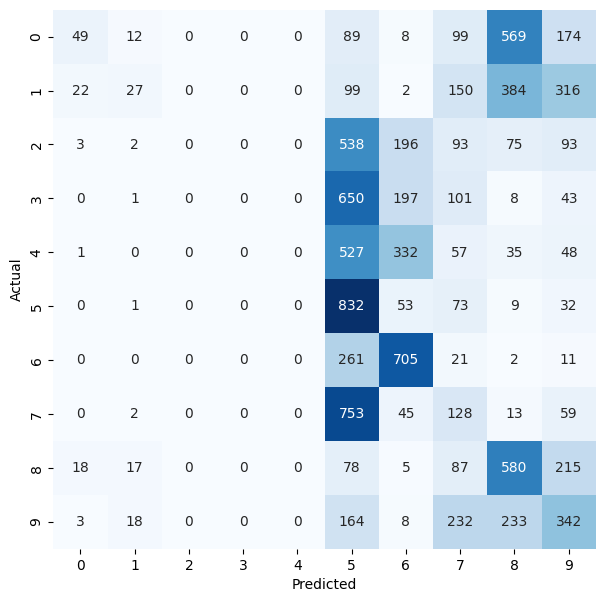

In [63]:
# Assuming you have a trained model and test data X_test
y_pred = inceptionv3_model.predict(resized_test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

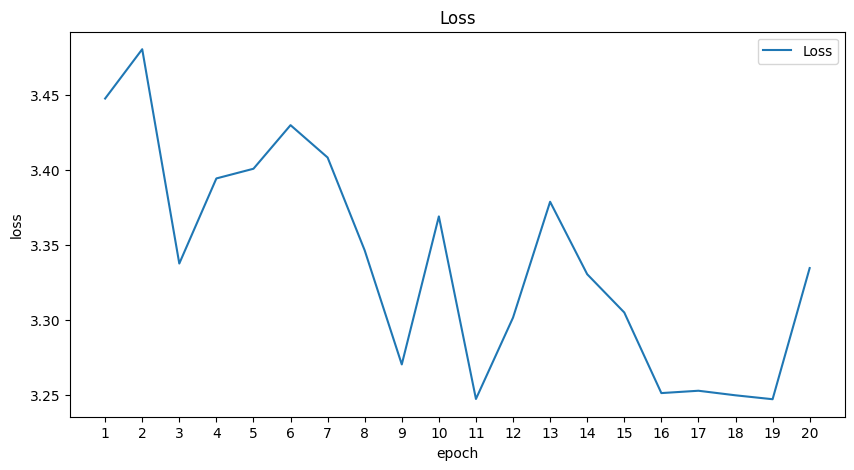

In [64]:
# reading the csv file
df = pd.read_csv('inception_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='Loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

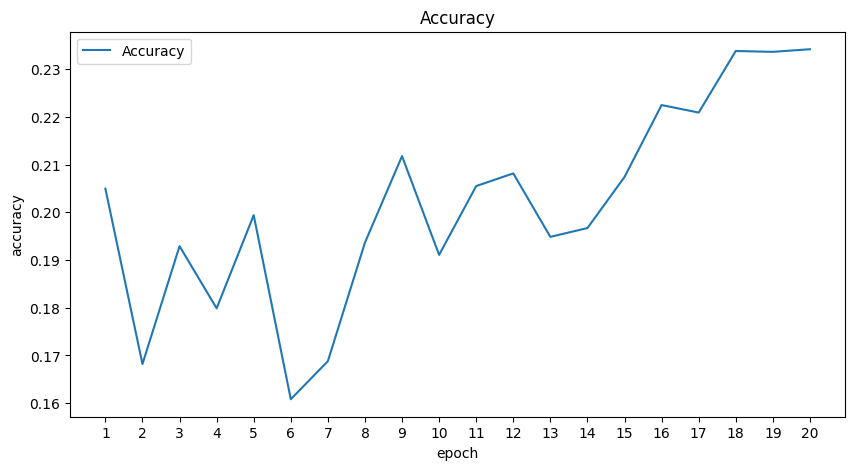

In [66]:
# reading the csv file
df = pd.read_csv('inception_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='Accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

### Using VGG19

In [67]:
from keras.applications import VGG19

# Load VGG19 with pre-trained weights and exclude the top layers
VGG = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [68]:
x = VGG.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation='softmax')(x)  # 10 classes in CIFAR-10

VGG_model = keras.models.Model(inputs=VGG.input, outputs=x)
VGG_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [69]:
VGG_history = VGG_model.fit(train_images, train_labels_one_hot, epochs=20, batch_size=64, validation_split=0.2)
VGG_model.save('VGG19.h5')
print("Saved model to disk")

df = pd.DataFrame(VGG_history.history)
df.to_csv("VGG_history.csv")

Epoch 1/20
625/625 [==============================] - 36s 47ms/step - loss: 1.9667 - accuracy: 0.2022 - val_loss: 1.7546 - val_accuracy: 0.2981
Epoch 2/20
625/625 [==============================] - 28s 46ms/step - loss: 1.7220 - accuracy: 0.3044 - val_loss: 1.6756 - val_accuracy: 0.3513
Epoch 3/20
625/625 [==============================] - 28s 45ms/step - loss: 1.4942 - accuracy: 0.4137 - val_loss: 1.4277 - val_accuracy: 0.4595
Epoch 4/20
625/625 [==============================] - 28s 45ms/step - loss: 1.2462 - accuracy: 0.5457 - val_loss: 1.2297 - val_accuracy: 0.5798
Epoch 5/20
625/625 [==============================] - 28s 45ms/step - loss: 1.0498 - accuracy: 0.6304 - val_loss: 1.0704 - val_accuracy: 0.6345
Epoch 6/20
625/625 [==============================] - 28s 45ms/step - loss: 0.9426 - accuracy: 0.6735 - val_loss: 1.0025 - val_accuracy: 0.6634
Epoch 7/20
625/625 [==============================] - 28s 45ms/step - loss: 0.8644 - accuracy: 0.7042 - val_loss: 1.0150 - val_accuracy:

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


#### Model Importing

In [70]:
# Load the model using custom_objects
VGG_model = keras.models.load_model('VGG19.h5', custom_objects={"accuracy": "accuracy"})

In [71]:
evaluation = VGG_model.evaluate(test_images, test_labels_one_hot, verbose=1)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')
VGG_model.summary()

313/313 [==============================] - 4s 10ms/step - loss: 1.0005 - accuracy: 0.7824
Test Loss: 1.0004594326019287
Test Accuracy: 0.7824000120162964
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 1

313/313 [==============================] - 3s 9ms/step


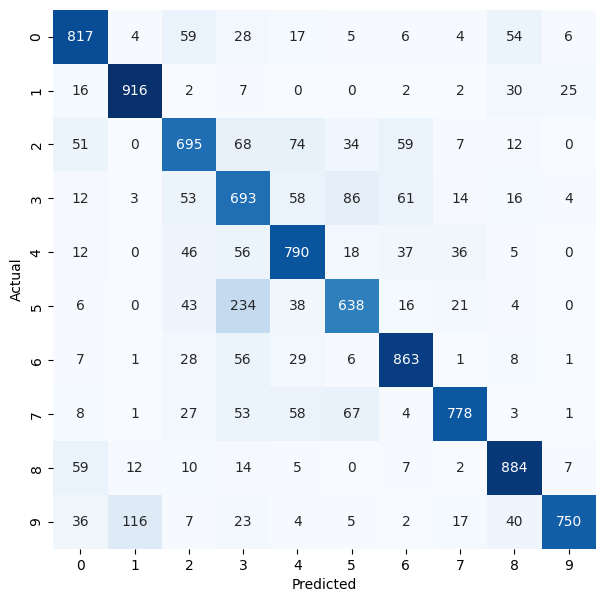

In [72]:
# Assuming you have a trained model and test data X_test
y_pred = VGG_model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

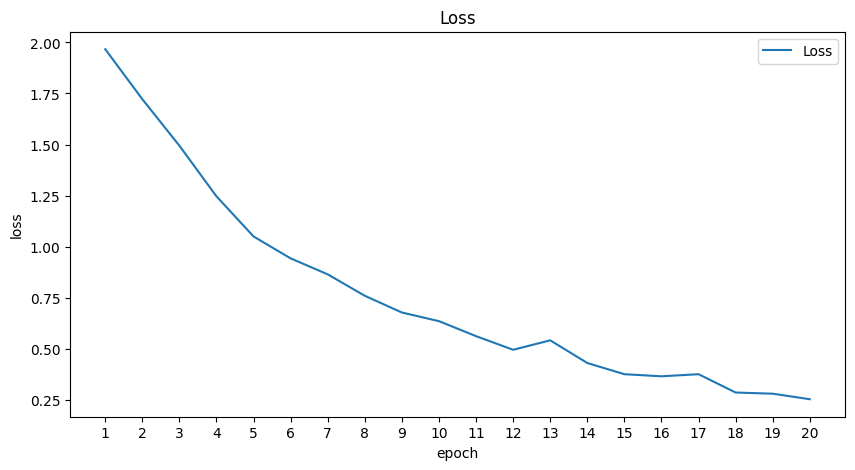

In [73]:
# reading the csv file
df = pd.read_csv('VGG_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='Loss')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

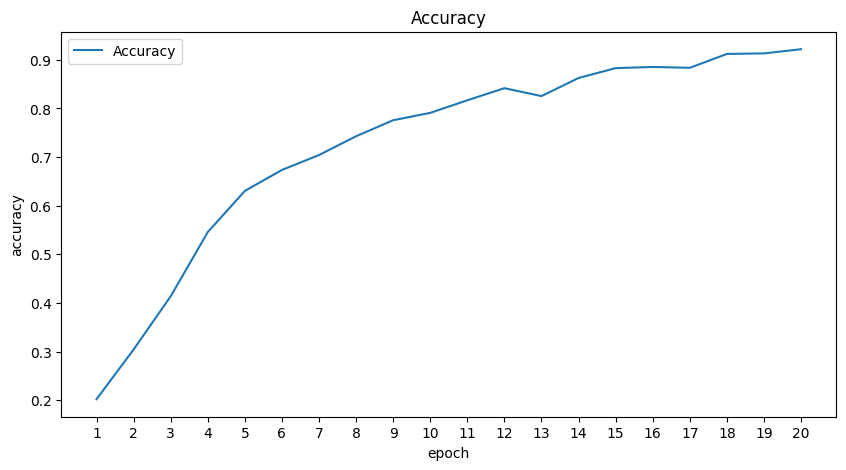

In [74]:
# reading the csv file
df = pd.read_csv('VGG_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='Accuracy')
ax.set_xticks(np.arange(1, 21))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()

# Using RESNET50

In [12]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [13]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
    return feature_extractor

def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(7, 7))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

def define_compile_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))
    classification_output = final_model(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=classification_output)

    model.compile(optimizer='SGD',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [14]:
resnet_model = define_compile_model()
resnet_history = resnet_model.fit(train_images, train_labels, validation_split=0.2, epochs=5, batch_size=64)
resnet_model.save('resnet_model.h5')

Epoch 1/5
625/625 [==============================] - 217s 325ms/step - loss: 0.5276 - accuracy: 0.8247 - val_loss: 2.6734 - val_accuracy: 0.1664
Epoch 2/5
625/625 [==============================] - 202s 323ms/step - loss: 0.1416 - accuracy: 0.9541 - val_loss: 0.2404 - val_accuracy: 0.9230
Epoch 3/5
625/625 [==============================] - 202s 323ms/step - loss: 0.0507 - accuracy: 0.9849 - val_loss: 0.2109 - val_accuracy: 0.9341
Epoch 4/5
625/625 [==============================] - 202s 323ms/step - loss: 0.0181 - accuracy: 0.9959 - val_loss: 0.2226 - val_accuracy: 0.9407
Epoch 5/5
625/625 [==============================] - 202s 323ms/step - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.2433 - val_accuracy: 0.9373


In [22]:
df = pd.DataFrame(resnet_history.history)
df.to_csv("resnet_history.csv")

#### Model import

In [16]:
# Load the model using custom_objects
resnet_model = keras.models.load_model('resnet_model.h5', custom_objects={"accuracy": "accuracy"})

#### Model Accuracy

In [17]:
evaluation = model.evaluate(test_images, test_labels, verbose=1)
print(f'Test Loss: {evaluation[0]}')
print(f'Test Accuracy: {evaluation[1]}')

313/313 [==============================] - 16s 51ms/step - loss: 0.2194 - accuracy: 0.9414
Test Loss: 0.21939270198345184
Test Accuracy: 0.9413999915122986


313/313 [==============================] - 16s 48ms/step


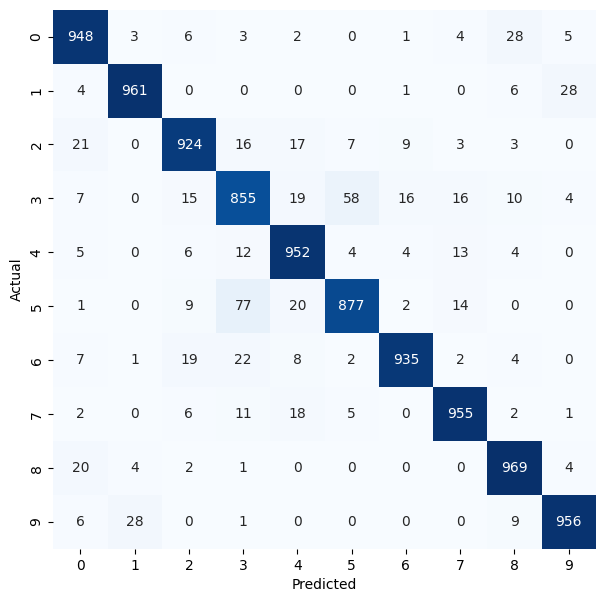

In [18]:
# Assuming you have a trained model and test data X_test
y_pred = resnet_model.predict(test_images)

cm = confusion_matrix(test_labels, np.argmax(y_pred, axis=1))
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

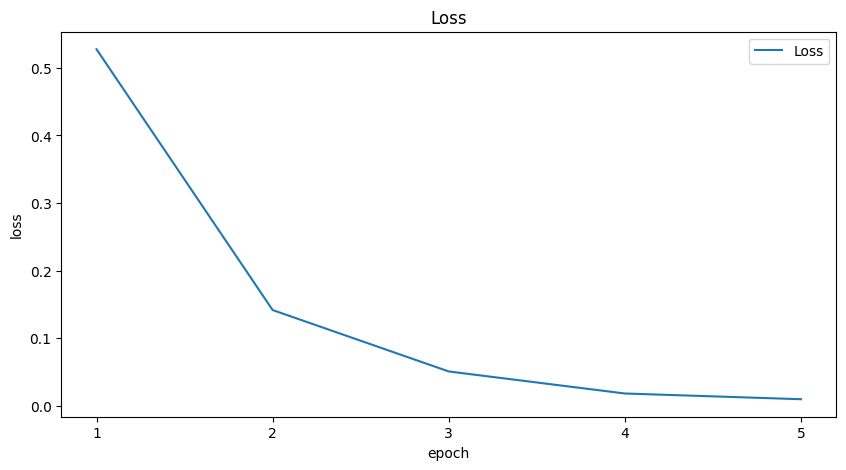

In [19]:
# reading the csv file
df = pd.read_csv('resnet_history.csv')
loss = df['loss']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(loss) + 1)
ax.plot(x_values, loss, label='Loss')
ax.set_xticks(np.arange(1, 6))
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Loss')
ax.legend()
plt.show()

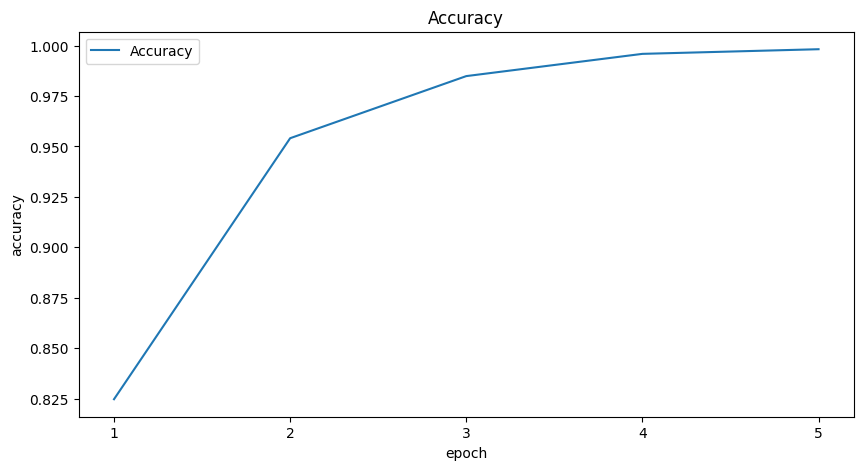

In [21]:
# reading the csv file
df = pd.read_csv('resnet_history.csv')
accuracy = df['accuracy']
fig, ax = plt.subplots(figsize=(10, 5))
x_values = np.arange(1, len(accuracy) + 1)
ax.plot(x_values, accuracy, label='Accuracy')
ax.set_xticks(np.arange(1, 6))
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy')
ax.legend()
plt.show()